In [69]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import scipy as sp
import requests

In [70]:
data = pd.read_parquet(Path("data") / "train.parquet")

In [71]:
import problem

X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()

In [72]:
df_weather = pd.read_csv("external_data.csv")
df_weather['date'] = pd.to_datetime(df_weather.date)
df_weather.drop(df_weather.columns[0], axis=1, inplace=True)
df_weather.head()

,date,Temperature (C),wind_dir,wind_speed,Humidity,Visibility,Precipitation,pressure1
0,2020-09-01 23:00:00,14.9,NNE,5.6,63.0,2.995732,0,1019.1
1,2020-09-01 22:00:00,15.2,NNE,5.6,59.0,2.995732,0,1019.0
2,2020-09-01 21:00:00,16.4,NE,7.4,52.0,2.995732,0,1018.9
3,2020-09-01 20:00:00,17.1,NNE,7.4,49.0,2.995732,0,1018.5
4,2020-09-01 19:00:00,18.5,NNE,5.6,46.0,2.995732,0,1017.9


In [73]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

In [74]:
from sklearn.preprocessing import FunctionTransformer

date_encoder = FunctionTransformer(_encode_dates, validate=False)
date_encoder.fit_transform(data[["date"]]).head()

,year,month,day,weekday,hour
48321,2020,9,1,1,2
48324,2020,9,1,1,3
48327,2020,9,1,1,4
48330,2020,9,1,1,15
48333,2020,9,1,1,18


In [75]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False)

enc.fit_transform(_encode_dates(data[["date"]])[["hour"]].head())

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [76]:
#COPY THIS CELL
X_train_comb = X_train.join(df_weather.set_index("date"), on="date") 
print(X_train_comb.shape)
X_train_comb["y_train"] = y_train.copy()
X_train_comb.dropna(inplace=True)
print(X_train_comb.shape)

y_train = X_train_comb["y_train"]
X_train_comb.drop("y_train", axis=1, inplace=True)

#Do the same operations for X_test
X_test_comb = X_test.join(df_weather.set_index("date"), on="date") 
print(X_test_comb.shape)
X_test_comb["y_test"] = y_test.copy()
X_test_comb.dropna(inplace=True)
print(X_test_comb.shape)

y_test = X_test_comb["y_test"]
X_test_comb.drop("y_test", axis=1, inplace=True)
X_test_comb.shape, y_test.shape

(455163, 17)
(448861, 18)
(41608, 17)
(41384, 18)


((41384, 17), (41384,))

In [77]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train_comb[["date"]]).columns.tolist()
scaler = StandardScaler()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name", "wind_dir"]
numerical_cols = X_train_comb.select_dtypes(include=np.number).columns

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        #("scaler", scaler, numerical_cols)
    ]
)

regressor = Ridge()

pipe0 = make_pipeline(date_encoder, preprocessor, regressor)
pipe0.fit(X_train_comb, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x0000024B0DA23250>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'wind_dir'])])),
                ('ridge', Ridge())])

In [78]:
from sklearn.metrics import mean_squared_error

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe0.predict(X_train_comb), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe0.predict(X_test_comb), squared=False):.2f}"
)

Train set, RMSE=0.80
Test set, RMSE=0.72


In [79]:
from sklearn.metrics import r2_score

print(
    f"Train set, R^2={r2_score(y_train, pipe0.predict(X_train_comb)):.2f}"
)
print(
    f"Test set, R^2={r2_score(y_test, pipe0.predict(X_test_comb)):.2f}"
)

Train set, R^2=0.77
Test set, R^2=0.75


We are using Hist Gradient Boosting since our data set is large

In [21]:
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

In [85]:
date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train_comb[["date"]]).columns.tolist()
scaler = StandardScaler()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name", "wind_dir"]
numerical_cols = X_train_comb.select_dtypes(include=np.number).columns

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        ("scaler", scaler, numerical_cols)
    ]
)
params = {
    'n_estimators':[500],
    'min_child_weight':[4,5], 
    'gamma':[i/10.0 for i in range(3,6)],  
    'subsample':[i/10.0 for i in range(6,11)],
    'colsample_bytree':[i/10.0 for i in range(6,11)], 
    'max_depth': [2,3,4,6,7],
    'objective': ['reg:squarederror', 'reg:tweedie'],
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': ['rmse'],
    'eta': [i/10.0 for i in range(3,6)],
}

Boost = XGBRegressor()

pipe2 =make_pipeline(date_encoder, preprocessor, RandomizedSearchCV(Boost, param_distributions=params,
                                   n_iter=10, cv=7, scoring='neg_mean_squared_error'))
pipe2.fit(X_train_comb, y_train)

[14:57:01] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[14:57:19] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[14:57:37] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[14:57:55] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x0000024B0DA23250>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'wind_dir']),
                                                 ('scaler', St...
                                                           random_state=None, ...),
                                    param_distributions={'booster': ['gbtree',
                                                                     'gblinear'],
                                                         'colsample_bytree': [0.6,
                                                                              0.7,
                                                                              0.8,
                                                                              0.9,
                                                                              1.0],
                                                         'eta': [0.3, 0.4, 0.5],
                                                         'eval_metric': ['rmse'],
                                                         'gamma': [0.3, 0.4,
                                                                   0.5],
                                                         'max_depth': [2, 3, 4,
                                                                       6, 7],
                                                         'min_child_weight': [4,
                                                                              5],
                                                         'n_estimators': [500],
                                                         'objective': ['reg:squarederror',
                                                                       'reg:tweedie'],
                                                         'subsample': [0.6, 0.7,
                                                                       0.8, 0.9,
                                                                       1.0]},
                                    scoring='neg_mean_squared_error'))])

In [86]:
pipeb = pipe2[2].best_estimator

In [116]:
pipeb.set_params()

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
             early_stopping_rounds=None, enable_categorical=False, eta=0.3,
             eval_metric='rmse', feature_types=None, gamma=0.3, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=7, max_leaves=0, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', ...)

In [87]:
import joblib
joblib.dump(pipe2, 'XGB')
joblib.dump(pipe2[2].best_estimator_, 'XGB Best Model')

['XGB Best Model']

In [88]:
joblib.load('XGB Best Model')

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
             early_stopping_rounds=None, enable_categorical=False, eta=0.3,
             eval_metric='rmse', feature_types=None, gamma=0.3, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=7, max_leaves=0, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', ...)

In [89]:
pd.DataFrame(pipe2[2].cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_objective,param_n_estimators,param_min_child_weight,param_max_depth,param_gamma,...,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,mean_test_score,std_test_score,rank_test_score
0,47.092297,2.373504,0.233310,0.051469,0.6,reg:tweedie,500,4,6,0.4,...,-1.080881,-0.894060,-0.946249,-1.118680,-0.607408,-0.429871,-0.586647,-0.809114,0.247765,6
1,55.018787,3.741671,0.285418,0.028732,0.7,reg:squarederror,500,4,7,0.3,...,-0.572395,-0.481343,-0.557812,-0.611437,-0.492356,-0.329606,-0.524928,-0.509983,0.084824,2
2,18.010847,0.258236,0.014647,0.000580,0.9,reg:tweedie,500,5,3,0.3,...,-0.851956,-1.364684,-0.753779,-0.789978,-0.613010,-1.044671,-1.035469,-0.921935,0.229907,9
3,18.021953,0.321678,0.015147,0.001457,0.9,reg:tweedie,500,4,7,0.4,...,-0.865441,-1.072172,-0.753779,-0.755831,-0.617228,-1.044671,-1.044980,-0.879158,0.165560,7
4,15.952332,0.220688,0.013432,0.001499,1.0,reg:squarederror,500,4,2,0.5,...,-0.704829,-0.911739,-0.738730,-0.781230,-0.597226,-0.868416,-0.865257,-0.781061,0.102257,5
5,46.539555,1.244767,0.227234,0.010683,0.8,reg:squarederror,500,4,6,0.5,...,-0.582262,-0.482466,-0.600664,-0.626095,-0.470884,-0.326299,-0.504072,-0.513249,0.094804,3
6,18.732521,0.697631,0.015168,0.001278,0.8,reg:tweedie,500,4,7,0.5,...,-0.963581,-1.249443,-0.753779,-0.791139,-0.612673,-1.044671,-1.034026,-0.921330,0.199159,8
7,58.777559,3.216147,0.287566,0.029959,0.7,reg:tweedie,500,4,7,0.3,...,-1.117982,-1.057260,-0.960990,-1.546186,-0.605944,-0.569053,-0.673761,-0.933025,0.323611,10
8,27.917474,0.458374,0.074603,0.006395,0.6,reg:squarederror,500,5,2,0.4,...,-0.735021,-0.523900,-0.613533,-0.722485,-0.546490,-0.479088,-0.630248,-0.607252,0.090425,4
9,54.694251,0.814029,0.285158,0.006325,0.9,reg:squarederror,500,4,7,0.3,...,-0.537708,-0.501107,-0.558374,-0.580037,-0.475642,-0.339460,-0.570610,-0.508991,0.077481,1


<AxesSubplot:>

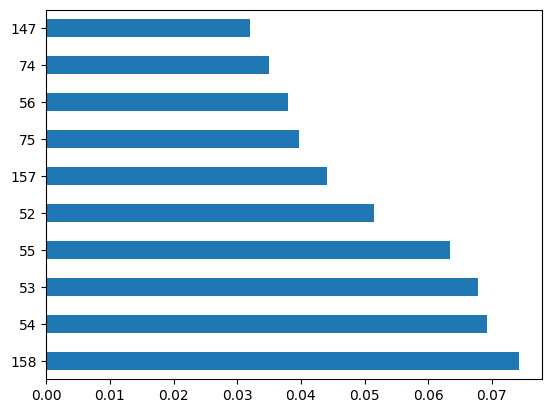

In [106]:
(pd.Series(pipeb.feature_importances_)
   .nlargest(10)
   .plot(kind='barh'))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

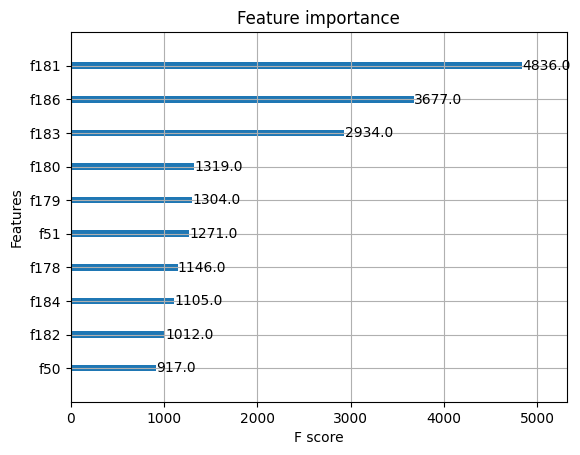

In [102]:
xgb.plot_importance(pipeb,max_num_features=10,fmap="")


In [91]:
print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe2.predict(X_train_comb), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe2.predict(X_test_comb), squared=False):.2f}"
)

Train set, RMSE=0.32
Test set, RMSE=0.47


In [92]:
from sklearn.metrics import r2_score

print(
    f"Train set, R^2={r2_score(y_train, pipe2.predict(X_train_comb)):.2f}"
)
print(
    f"Test set, R^2={r2_score(y_test, pipe2.predict(X_test_comb)):.2f}"
)

Train set, R^2=0.96
Test set, R^2=0.89


In [93]:
mask = (
    (X_test_comb["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_test_comb["date"] > pd.to_datetime("2021/09/01"))
    & (X_test_comb["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_test_comb.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_test[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe2.predict(X_test_comb[mask])) - 1

Text(0, 0.5, 'bike_count')

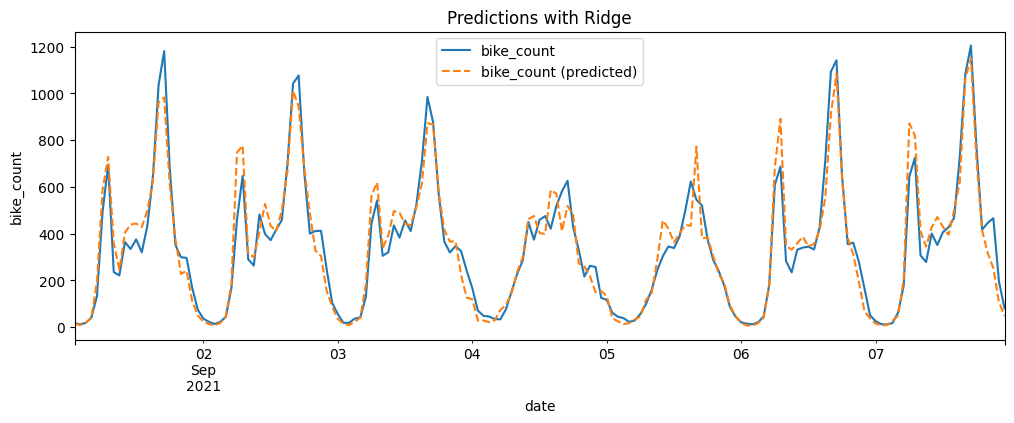

In [94]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge")
ax.set_ylabel("bike_count") 

## _LightGBM Regressor_

In [118]:
from lightgbm import LGBMRegressor

In [134]:
date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train_comb[["date"]]).columns.tolist()
scaler = StandardScaler()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name", "wind_dir"]
numerical_cols = X_train_comb.select_dtypes(include=np.number).columns

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        ("scaler", scaler, numerical_cols)
    ]
)
param_grid = {'learning_rate:':(.01,.02,.001,.1,.00002),
               'n_estimators':range(100,500,10),
               'max_depth': range(10,40,4),}

Boost = LGBMRegressor()

pipe3 =make_pipeline(date_encoder, preprocessor, RandomizedSearchCV(estimator = Boost, param_distributions = param_grid,
                                                                    cv = 7, verbose=2, random_state=42, n_jobs = -1))
pipe3.fit(X_train_comb, y_train)

Fitting 7 folds for each of 10 candidates, totalling 70 fits
[LightGBM] [Warning] Unknown parameter: learning_rate:


Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x0000024B0DA23250>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'wind_dir']),
                                                 ('scaler', St...
                                                  Index(['site_id', 'latitude', 'longitude', 'Temperature (C)', 'wind_speed',
       'Humidity', 'Visibility', 'Precipitation', 'pressure1'],
      dtype='object'))])),
                ('randomizedsearchcv',
                 RandomizedSearchCV(cv=7, estimator=LGBMRegressor(), n_jobs=-1,
                                    param_distributions={'learning_rate:': (0.01,
                                                                            0.02,
                                                                            0.001,
                                                                            0.1,
                                                                            2e-05),
                                                         'max_depth': range(10, 40, 4),
                                                         'n_estimators': range(100, 500, 10)},
                                    random_state=42, verbose=2))])

In [135]:
pipe3[2].best_estimator_

LGBMRegressor(learning_rate:=0.1, max_depth=34, n_estimators=480)

In [136]:
print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe3.predict(X_train_comb), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe3.predict(X_test_comb), squared=False):.2f}"
)

Train set, RMSE=0.45
Test set, RMSE=0.50


In [137]:
from sklearn.metrics import r2_score

print(
    f"Train set, R^2={r2_score(y_train, pipe3.predict(X_train_comb)):.2f}"
)
print(
    f"Test set, R^2={r2_score(y_test, pipe3.predict(X_test_comb)):.2f}"
)

Train set, R^2=0.93
Test set, R^2=0.88


In [138]:
mask = (
    (X_test_comb["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_test_comb["date"] > pd.to_datetime("2021/09/01"))
    & (X_test_comb["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_test_comb.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_test[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe3.predict(X_test_comb[mask])) - 1

Text(0, 0.5, 'bike_count')

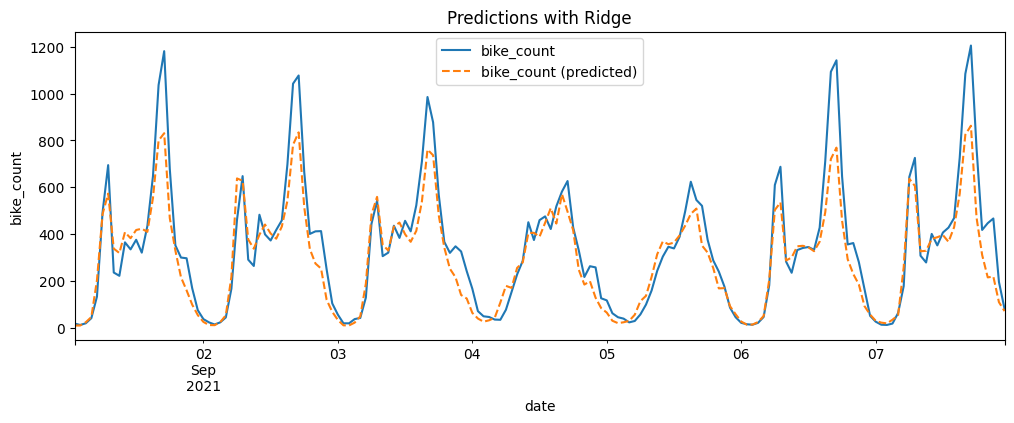

In [139]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge")
ax.set_ylabel("bike_count") 

In [140]:
import joblib
joblib.dump(pipe3, 'LGBM')
joblib.dump(pipe3[2].best_estimator_, 'LGBM Best Model')

['LGBM Best Model']

In [1]:
import joblib
joblib.load('LGBM Best Model')

LGBMRegressor(learning_rate:=0.1, max_depth=34, n_estimators=480)

## _CATBoost Regressor_

In [141]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

In [142]:
date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train_comb[["date"]]).columns.tolist()
scaler = StandardScaler()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name", "wind_dir"]
numerical_cols = X_train_comb.select_dtypes(include=np.number).columns

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        ("scaler", scaler, numerical_cols)
    ]
)
param_grid = {'depth':[6,8,1,15,20],
              'learning_rate': [.01,.02,.001,.1,.00002],
              'iterations': [30,50,100,200] }

Boost = CatBoostRegressor()

pipeC =make_pipeline(date_encoder, preprocessor, GridSearchCV(estimator = Boost, param_grid = param_grid,
                                                                    cv = 7, verbose=2,n_jobs = 4))
pipeC.fit(X_train_comb, y_train)

Fitting 7 folds for each of 100 candidates, totalling 700 fits


c:\Users\Rehan Ibrahim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
140 fits failed out of a total of 700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
140 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Rehan Ibrahim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Rehan Ibrahim\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py", line 5730, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, No

0:	learn: 1.5622326	total: 461ms	remaining: 1m 31s
1:	learn: 1.4635327	total: 918ms	remaining: 1m 30s
2:	learn: 1.3786646	total: 1.39s	remaining: 1m 31s
3:	learn: 1.3044336	total: 1.84s	remaining: 1m 30s
4:	learn: 1.2375289	total: 2.29s	remaining: 1m 29s
5:	learn: 1.1814704	total: 2.73s	remaining: 1m 28s
6:	learn: 1.1314686	total: 3.19s	remaining: 1m 27s
7:	learn: 1.0876836	total: 3.64s	remaining: 1m 27s
8:	learn: 1.0502829	total: 4.09s	remaining: 1m 26s
9:	learn: 1.0181369	total: 4.54s	remaining: 1m 26s
10:	learn: 0.9882554	total: 4.99s	remaining: 1m 25s
11:	learn: 0.9633047	total: 5.44s	remaining: 1m 25s
12:	learn: 0.9391255	total: 5.88s	remaining: 1m 24s
13:	learn: 0.9172041	total: 6.33s	remaining: 1m 24s
14:	learn: 0.8964501	total: 6.77s	remaining: 1m 23s
15:	learn: 0.8786363	total: 7.21s	remaining: 1m 22s
16:	learn: 0.8616187	total: 7.66s	remaining: 1m 22s
17:	learn: 0.8436247	total: 8.09s	remaining: 1m 21s
18:	learn: 0.8287126	total: 8.53s	remaining: 1m 21s
19:	learn: 0.8141456	t

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x0000024B0DA23250>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'wind_dir']),
                                                 ('scaler', St...
                                                  Index(['site_id', 'latitude', 'longitude', 'Temperature (C)', 'wind_speed',
       'Humidity', 'Visibility', 'Precipitation', 'pressure1'],
      dtype='object'))])),
                ('gridsearchcv',
                 GridSearchCV(cv=7,
                              estimator=<catboost.core.CatBoostRegressor object at 0x0000024B221980D0>,
                              n_jobs=4,
                              param_grid={'depth': [6, 8, 1, 15, 20],
                                          'iterations': [30, 50, 100, 200],
                                          'learning_rate': [0.01, 0.02, 0.001,
                                                            0.1, 2e-05]},
                              verbose=2))])

In [143]:
pipeC[2].best_estimator_

In [144]:
pd.DataFrame(pipeC[2].cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_depth,param_iterations,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,mean_test_score,std_test_score,rank_test_score
0,4.281517,0.261496,0.078758,0.017451,6,30,0.01,"{'depth': 6, 'iterations': 30, 'learning_rate'...",0.084857,0.170703,0.112642,0.150665,0.182072,0.174466,0.150943,0.146621,0.032986,44
1,4.301632,0.133640,0.119348,0.031848,6,30,0.02,"{'depth': 6, 'iterations': 30, 'learning_rate'...",0.221950,0.272823,0.222292,0.253612,0.291001,0.284871,0.276654,0.260457,0.026540,37
2,4.066174,0.270422,0.071403,0.010456,6,30,0.001,"{'depth': 6, 'iterations': 30, 'learning_rate'...",-0.100767,0.011299,-0.063020,-0.006617,0.021827,0.014334,-0.024390,-0.021048,0.042211,61
3,4.038790,0.329667,0.087004,0.033667,6,30,0.1,"{'depth': 6, 'iterations': 30, 'learning_rate'...",0.579732,0.614063,0.580387,0.590073,0.639463,0.585073,0.590555,0.597049,0.020355,17
4,3.776706,0.147815,0.071234,0.011576,6,30,0.00002,"{'depth': 6, 'iterations': 30, 'learning_rate'...",-0.127644,-0.012267,-0.088559,-0.030723,-0.001650,-0.009066,-0.050053,-0.045709,0.043417,77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.262990,0.096000,0.000000,0.000000,20,200,0.01,"{'depth': 20, 'iterations': 200, 'learning_rat...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83
96,1.310871,0.108927,0.000000,0.000000,20,200,0.02,"{'depth': 20, 'iterations': 200, 'learning_rat...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82
97,1.255226,0.078264,0.000000,0.000000,20,200,0.001,"{'depth': 20, 'iterations': 200, 'learning_rat...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81
98,1.283544,0.084169,0.000000,0.000000,20,200,0.1,"{'depth': 20, 'iterations': 200, 'learning_rat...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89


In [145]:
from sklearn.metrics import r2_score

print(
    f"Train set, R^2={r2_score(y_train, pipeC.predict(X_train_comb)):.2f}"
)
print(
    f"Test set, R^2={r2_score(y_test, pipeC.predict(X_test_comb)):.2f}"
)

Train set, R^2=0.93
Test set, R^2=0.88


In [146]:
print(
    f"Train set, RMSE={mean_squared_error(y_train, pipeC.predict(X_train_comb), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipeC.predict(X_test_comb), squared=False):.2f}"
)

Train set, RMSE=0.43
Test set, RMSE=0.49


In [147]:
mask = (
    (X_test_comb["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_test_comb["date"] > pd.to_datetime("2021/09/01"))
    & (X_test_comb["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_test_comb.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_test[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipeC.predict(X_test_comb[mask])) - 1

Text(0, 0.5, 'bike_count')

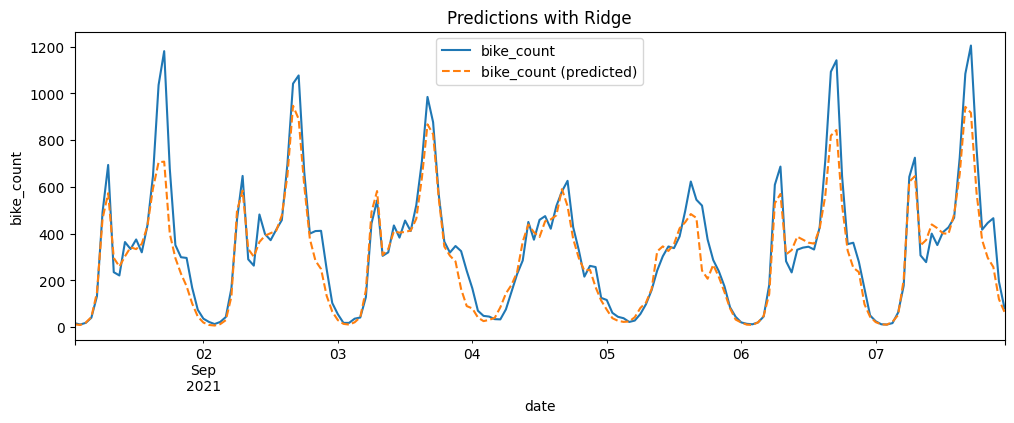

In [148]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge")
ax.set_ylabel("bike_count") 

In [149]:
import joblib
joblib.dump(pipe3, 'CatBoost')
joblib.dump(pipe3[2].best_estimator_, 'CatBoost Best Model')

['CatBoost Best Model']

## _Random Forest Regressor with GridSearchCV_

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train_comb[["date"]]).columns.tolist()
scaler = StandardScaler()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name", "wind_dir"]
numerical_cols = X_train_comb.select_dtypes(include=np.number).columns

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        ("scaler", scaler, numerical_cols)
    ]
)

RandomForest = RandomForestRegressor(bootstrap=True,oob_score=True)

param_grid = {'max_depth': np.arange(1, 15),
              'n_estimators': np.arange(1, 100, 15),
              'max_features':(.4,.2),
              'min_samples_leaf':(30,20),
              }

pipe4 = make_pipeline(
    date_encoder,
    preprocessor,
    GridSearchCV(RandomForest,
                 param_grid,
                 n_jobs=-1,
                 cv=3)
)
pipe4.fit(X_train_comb, y_train)

In [84]:
from sklearn.metrics import r2_score

print(
    f"Train set, R^2={r2_score(y_train, pipe4.predict(X_train_comb)):.2f}"
)
print(
    f"Test set, R^2={r2_score(y_test, pipe4.predict(X_test_comb)):.2f}"
)

NameError: name 'pipe4' is not defined

In [ ]:
df_result = pd.DataFrame(pipe4[-1].cv_results_)
display(df_result)

In [ ]:
mask = (
    (X_test_comb["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_test_comb["date"] > pd.to_datetime("2021/09/01"))
    & (X_test_comb["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_test_comb.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_test[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe4.predict(X_test_comb[mask])) - 1

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge")
ax.set_ylabel("bike_count")